## Exercise 1 : Two-dimensional Data
Jonas Kleine, Felix Exner, Philipp Köhler

### Representation of Dataset

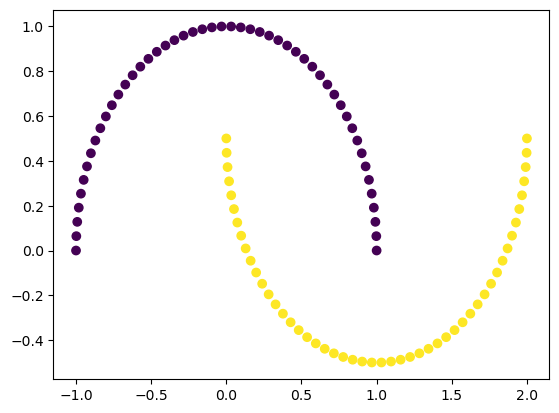

In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import numpy as np

import random
from scipy.stats import multivariate_normal

x,y = ds.make_moons()
x1= x[:,0] 
x2= x[:,1]

plt.scatter(x1, x2, c=y)

<div style="color: green; font-weight: bold;">Comment:</div>
Your representation of the dataset using make_moons() is correct and aligns well with the problem requirements. The scatter plot effectively visualizes the dataset distribution. However, it would be more concise and readable if you used directly plt.scatter(x[:,0], x[:,1], c=y) instead of storing each component into x1 and x2. It reduces redundancy in your code.

### Implementation of MMD metric 
we used a bandwidth of h=1

In [21]:
# implementationn of MMD metric

#definition of kernel functions
class inverse_quadr():
    def __init__(self, h=1.0):
        self.f = lambda x,y : 1/((np.abs(x-y)/h)**2 +1)
        
    def __call__(self,x,y):
        return self.f(x,y)
    
class exponential():
    def __init__(self, h=1.0):
        self.f = lambda x,y : np.exp(-np.abs(x-y)/h)
        
    def __call__(self,x,y):
        return self.f(x,y)

#MMD
class MMD:
    def __init__(self, test_true, test_model, kernel):
    # def __init__(self, kernel,x,y):
        """
        Parameters
        ----------
           test_true  
               testset (true data)
           test_model  
               testset (model data)
           kernel 
               used kernel for MMD
       ----------
       """
        self.test_true = test_true
        self.test_model = test_model
        self.ker = kernel
        
        
    def out(self):
      x = self.test_true
      y = self.test_model
      kernel = self.ker
      
      XX = np.array([[kernel(x_i, x_j) for x_j in x] for x_i in x])
      YY = np.array([[kernel(y_i, y_j) for y_j in y] for y_i in y])
      XY = np.array([[kernel(x_i, y_j) for y_j in y] for x_i in x])
        
      mmd_squared = np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)
      
      return mmd_squared
        

<div style="color: green; font-weight: bold;">Comment:</div>
The implementation of the kernel functions and the MMD metric is generally correct. However, it uses inefficient nested loops for calculating pairwise kernel evaluations, which makes it slow for large datasets. The scipy.spatial.distance.cdist() function can be used to vectorize these operations and improve efficiency. Moreover, the current implementation has a time complexity of O(n^2), which may lead to performance issues as the number of samples increases. Consider reducing this complexity using batch processing or approximations.

### Histogram Approach
(we used fixed bin size calculated via IQR following the lecture)

In [43]:
#%% histogram model

class hist():
    def __init__(self,X,N):
        """
       Parameters
       ----------
       N : int
           number drwan samples 
       """
        self.X= X
        self.N = N
        self.x1= X[:,0] 
        self.x2= X[:,1]
        #calc step size h= 2*IQR/N^(3/2) for each axis
        x1_sort = np.sort(x1)
        IQR1 = abs(x1_sort[int(3*len(self.x1)/4)] - x1_sort[int(len(self.x1)/4)])
        h1 = 2*IQR1 / len(self.x1)**(1/3)

        x2_sort = np.sort(self.x2)
        IQR2 = abs(x2_sort[int(3*len(self.x2)/4)] - x1_sort[int(len(self.x2)/4)])
        h2 = 2*IQR2 / len(self.x2)**(1/3)

        #number of steps M for each axis
        self.x1min= x1_sort[0]
        self.x1max= x1_sort[-1]
        self.x2min= x2_sort[0]
        self.x2max= x2_sort[-1]

        self.M1 = int(np.ceil((self.x1max - self.x1min) / h1))
        self.M2 = int(np.ceil((self.x2max - self.x2min) / h2))
        
    def create_hist(self):
        x1= self.x1
        x2= self.x2
        M1= self.M1
        M2= self.M2
        x1min = self.x1min
        x1max = self.x1max
        x2min = self.x2min
        x2max = self.x2max
        
        hist = (plt.hist2d(x1,x2, bins = [M1,M2], range = [[x1min,x1max],[x2min,x2max]]))[0]
        
        return hist
    
    def sample(self):
        n= self.N
        hist = self.create_hist()
        dim = hist.shape
        # samples2d = np.zeros((dim))
        
        weights = hist.ravel()
        samples = np.zeros(len(weights))
        weights = weights/sum(weights) #normalize
        
        for i in range(n):
            sampled_bin = np.random.choice(len(weights), p=weights)
            # sampled_bin = np.unravel_index(sampled_bin, dim)
            
            samples[sampled_bin] += 1
        
        return samples
    
    def bin_to_coord(self,Bin):
        M1 = self.M1
        M2 = self.M2
        
        Bin = np.unravel_index(Bin, (M1,M2))
        bin1 = Bin[0]
        bin2 = Bin[1]
   
        x1min = self.x1min
        x1max = self.x1max
        x2min = self.x2min
        x2max = self.x2max
        
        delta1 = (x1max - x1min ) / M1
        delta2 = (x2max - x2min ) / M2
        
        x1 = x1min + (bin1*delta1) + delta1/2
        x2 = x2min + (bin2*delta2) + delta2/2
        
        return [x1,x2]
    
    def binSample_to_coordSample(self):
        sampled_bins = self.sample()
        
        samples = []
        
        for i in range(len(sampled_bins)):
            Bin = i
            for j in range(int(sampled_bins[i])):
                samples.append(self.bin_to_coord(Bin))
                
        return samples
        
    
    

Text(0.5, 1.0, 'estimated density and true data')

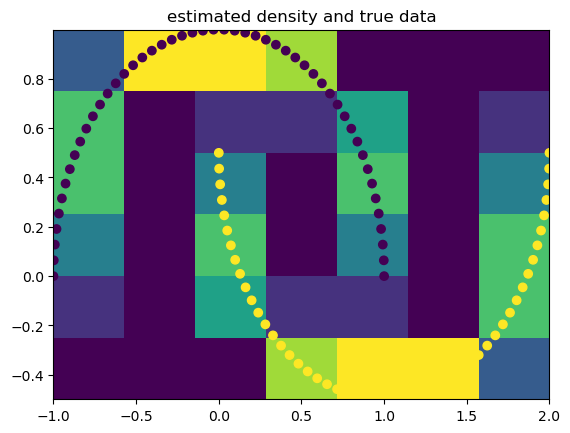

In [44]:
# eval Hist
hist_model = hist(x,40)
hist_model.create_hist()
plt.scatter(x1, x2, c=y)
plt.title("estimated density and true data")

<div style="color: green; font-weight: bold;">Comment:</div>
Your approach to calculating the step size using IQR is correct, following the lecture's methodology. However, in x1_sort[int(3*len(self.x1)/4)], there is an inconsistency where you use x1_sort instead of x2_sort. This could lead to incorrect calculations for h2. Additionally, using plt.hist2d is a good choice for generating the histogram. Nevertheless, the sample() method could be optimized by leveraging numpy more effectively to reduce the use of explicit loops.

#### Evaluation with MMD 
(using the full dataset and a test sample of size 40)

MMD-scores:
exponential Kernel: 0.01703
inv. Quadratic Kernel: 0.00368


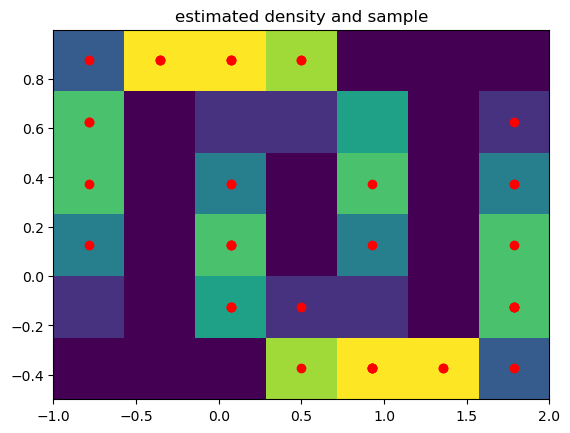

In [66]:
# sample Hist
sample_hist = np.array(hist_model.binSample_to_coordSample())
plt.scatter(sample_hist[:,0],sample_hist[:,1], color="red")
plt.title("estimated density and sample")
metric_exp = MMD(test_true = x, test_model = sample_hist, kernel = exponential())
print("MMD-scores:")
print("exponential Kernel:",round(metric_exp.out(),5))
metric_invQdr = MMD(test_true = x, test_model = sample_hist, kernel = inverse_quadr())
print("inv. Quadratic Kernel:",round(metric_invQdr.out(),5))


<div style="color: green; font-weight: bold;">Comment:</div>
The MMD evaluation is well presented, but a more comprehensive evaluation would involve running multiple experiments to gauge consistency. Additionally, consider plotting the MMD scores for different sample sizes to visualize the performance of the histogram model.

### Single Gaussian Approach

In [52]:
#%% single gaussian
class single_gaussian():
    def __init__(self, x):
        self.X = x
        self.mean = sum(x)/len(x)
        self.cov = np.cov(x.T)
        
        self.density= multivariate_normal(self.mean, self.cov)
        
    def plot(self):
        x = self.X
        cov = self.cov
        density = self.density
        
        x1= x[:,0] 
        x2= x[:,1]
        x1_plot = np.linspace(min(x1), max(x1), 100)
        x2_plot = np.linspace(min(x2), max(x2), 100)
        X1_plot, X2_plot = np.meshgrid(x1_plot, x2_plot)
        X_eval = np.dstack((X1_plot, X2_plot))
        detCov= np.linalg.det(cov)
        invCov= np.linalg.inv(cov)
        
        Z = density.pdf(X_eval)
        
        plt.figure(1)
        plt.clf()
        plt.contour(X1_plot, X2_plot, Z)
        
    def sample(self, N):
        """
       Parameters
       ----------
       N : int
           number of drawn samples 
       """
        density = self.density
        samples = density.rvs(size = N)
        
        return samples
        

Text(0.5, 1.0, 'estimated density and true data')

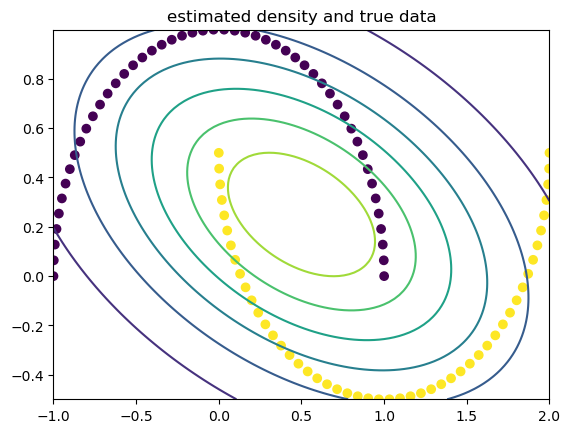

In [53]:
#%% eval single gaussian    
single_gaussian = single_gaussian(x)
single_gaussian.plot()
plt.scatter(x1, x2, c=y)
plt.title("estimated density and true data")

#### Evaluation with MMD 

MMD-scores:
exponential Kernel: 0.01918
inv. Quadratic Kernel: 0.01024


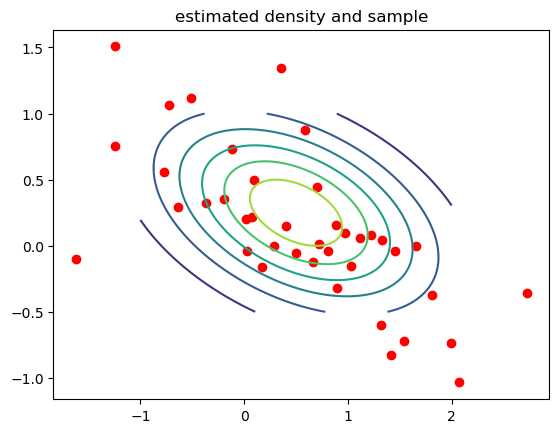

In [67]:
# sample single gaussian
sample_single_gaussian = single_gaussian.sample(40)
single_gaussian.plot()
plt.scatter(sample_single_gaussian[:,0],sample_single_gaussian[:,1], color ="red")
plt.title("estimated density and sample")
metric_exp = MMD(test_true = x, test_model = sample_single_gaussian, kernel = exponential())
print("MMD-scores:")
print("exponential Kernel:",round(metric_exp.out(),5))
metric_invQdr = MMD(test_true = x, test_model = sample_single_gaussian, kernel = inverse_quadr())
print("inv. Quadratic Kernel:",round(metric_invQdr.out(),5))


<div style="color: green; font-weight: bold;">Comment:</div>
 The single_gaussian implementation is correct in terms of calculating mean and covariance. However, using sum(x)/len(x) is inefficient; np.mean(x, axis=0) is more concise and optimized for array calculations. This change will make your code more efficient and readable.

### GMM approach

In [56]:
#%% GMM model
class GMM:
    def __init__(self, n: int, X):
        """
       Parameters
       ----------
       n : int
           number of gaussian clusters 

       """
        self.n = n  #number of gaussians in the model
        self.X = X  #data points
        
        #initialize weights 
        self.w = [random.random() for i in range(self.n)]
        self.w = self.w / np.sum(self.w) #normalize weights 
        
        self.means = [
            [random.uniform(min(X[:,0]),max(X[:,0])) , random.uniform(min(X[:,1]),max(X[:,1])) ] 
                                                                   for j in range(self.n)]
        self.covs = [np.eye(2)/20 for i in range(self.n) ]
        # self.covs = [ (np.var(X, axis=0)) * self.n for i in range(self.n) ]
        self.R = np.zeros((len(self.X),n)) 
        # print(self.means)
        
        
    def e_step(self):
       
        #load weights
        means = self.means
        covs = self.covs
        X = self.X
        n= self.n
        w = self.w
        R= self.R
        
        
        #compute responsibilities for every datapoint x_n in every cluster k
        for i in range(len(X)):
            for k in range(n):
                P = multivariate_normal.pdf(X[i,:], means[k], covs[k])
                R[i,k] = w[k] * P
            R[i,:] = R[i,:] / sum(R[i,:]) # normalize over k
            
        self.R = R + 1e-6
        
    
    def m_step(self):     
        
        covs = self.covs
        X = self.X
        n= self.n
        R= self.R
        
        means_updated = [
            (sum(R[:,k].reshape(len(X),1) * X)) / sum(R[:,k]) 
            for k in range(n)]
        
        covs_updated = [
                        sum( 
                            [ (R[i,k] * X[i].reshape(2,1) @ X[i].reshape(2,1).T) / sum(R[:,k])
                         for i in range(len(X))] 
                            )
                        - means_updated[k].reshape(2,1) @ means_updated[k].reshape(2,1).T
            for k in range(n)]
        
        weights_updated = [sum(R[:,k])/len(X) for k in range(n)]
        
        self.means = means_updated
        self.covs = covs_updated
        self.w = weights_updated
        
    def output(self):
        return self.means, self.covs, self.w
    
    def sample(self, N):
        weights = self.w
        covs = self.covs
        means = self.means
        #normalization of weights needed bcs numerical inaccuracy
        weights = weights / sum(weights)
        
        index = np.random.choice(len(weights), size=N, p=weights)
        samples = [np.random.multivariate_normal(means[i] , covs[i]) for i in index]
        
        return samples
        

    def plot(self):
        x = self.X
        means,covs, weights = self.output()
        
        x1= x[:,0] 
        x2= x[:,1]
        x_plot = np.arange(min(x1), max(x1), 0.01)
        y_plot = np.arange(min(x2), max(x2), 0.01)
        x_plot_grid, y_plot_grid = np.meshgrid(x_plot, y_plot)
        coordinates = np.array([x_plot_grid.ravel(), y_plot_grid.ravel()]).T   
            
        plt.figure(1)
        plt.clf()
        
        for i in range(nGaussians):
                mean = means[i]
                cov = covs[i]
                z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_plot_grid.shape)
                plt.contour(x_plot_grid, y_plot_grid, z_grid)
        
 

Text(0.5, 1.0, 'estimated density and true data \n 20 gaussians, 20 iterations')

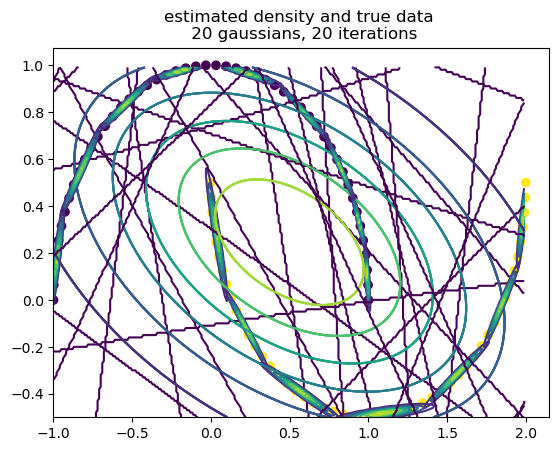

In [58]:
#%% GMM eval
nGaussians = 20
nIter = 20

GMM_model=GMM(nGaussians,x)
for i in range(nIter):
    GMM_model.e_step()
    GMM_model.m_step()
    
GMM_model.plot() 
plt.scatter(x1, x2, c=y)
plt.title("estimated density and true data \n 20 gaussians, 20 iterations")

#### Evaluation with MMD 

Text(0.5, 1.0, 'estimated density and sample\n 20 Gaussians and 20 iterations')

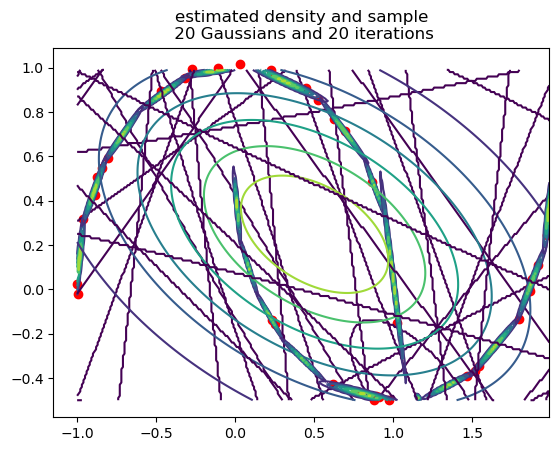

In [65]:
#sampled data
GMM_model= GMM(20,x)
for i in range(20):
        GMM_model.e_step()
        GMM_model.m_step()
sample_GMM = np.array(GMM_model.sample(40))
GMM_model.plot()
plt.scatter(sample_GMM[:,0],sample_GMM[:,1], color="red")
plt.title("estimated density and sample\n 20 Gaussians and 20 iterations")

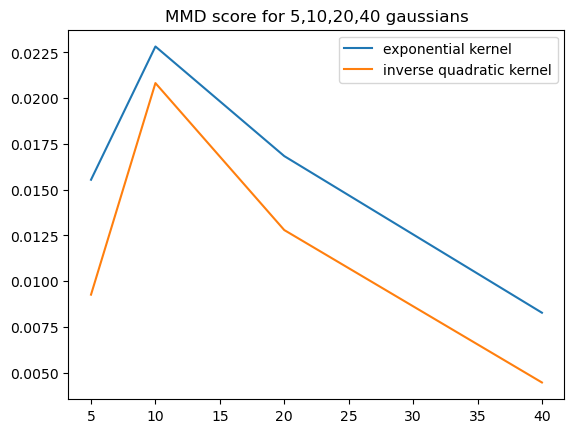

In [35]:
#GMM sample
nGaussians = [5,10,20,40]
nIter = 10
GMM_samples = []

for n in np.arange(4):
    current_n = nGaussians[n]
    GMM_model= GMM(current_n,x)
    for i in range(nIter):
        GMM_model.e_step()
        GMM_model.m_step()
    sample = np.array(GMM_model.sample(40))
    #print(sample.shape)
    GMM_samples.append(sample)

MMD_exp_GMM = []
MMD_inv_GMM = []
for n in np.arange(4):
    metric_exp = MMD(test_true = x, test_model = GMM_samples[n], kernel = exponential())
    metric_inv = MMD(test_true = x, test_model = GMM_samples[n], kernel = inverse_quadr())
    MMD_exp_GMM.append(metric_exp.out())
    MMD_inv_GMM.append(metric_inv.out())

plt.plot(nGaussians, MMD_exp_GMM, label ="exponential kernel")
plt.plot(nGaussians, MMD_inv_GMM, label ="inverse quadratic kernel")
plt.title("MMD score for 5,10,20,40 gaussians")
plt.legend()


<div style="color: green; font-weight: bold;">Comment:</div>
Your GMM implementation follows the expectation-maximization (EM) approach well, and initializing the means using random values is a valid starting point. However, using kmeans_plusplus for initializing cluster centroids, as demonstrated in the sample solution, would lead to more stable convergence and better results. In m_step(), the covariance update can be improved by ensuring that it remains positive definite by adding a small regularization term (e.g., epsilon = 1e-6) to the diagonal elements.

### KDE approach

In [32]:
#%% KDE with Gaussian Kernel

class KDE_gaussian():
    def __init__(self, X, H):
        """
       Parameters
       ----------
       H : array_like 
           bandwidth of kernel (cov-matrix)
       X : array_like 
           observed Data Points
       """
        self.H = H
        self.X = X  
        
    def ker(self, y):
        """
       Definition of Gaussian Kernel
       ----------
       x : points to evaluate
       y : datapoint
       """
        H= self.H
        
        # return multivariate_normal.pdf(x, mean=y, cov=H)#
        return multivariate_normal(mean=y, cov=H)
    
    def density_plot(self):
        X= self.X
        N = len(X)
        #creating points to evaluate the density
        x1= X[:,0] 
        x2= X[:,1]
        x1_eval = np.arange(min(x1), max(x1), 0.01)
        x2_eval = np.arange(min(x2), max(x2), 0.01)
        x1_grid, x2_grid = np.meshgrid(x1_eval, x2_eval)
        X_eval = np.dstack((x1_grid, x2_grid))

        # initialize density matrix
        P= np.zeros((len(x1_eval),len(x2_eval))) 
        
        for i in range(N):
            mean = X[i,:]
            # p= self.ker(mean, X_eval).T
            p= self.ker(mean).pdf(X_eval).T
            P += p
            
        P = P/N
        plt.figure(1)
        plt.clf()
        plt.contourf(x1_grid, x2_grid, P.T)
        
    def sample(self,N):
        X= self.X
        
        indices = np.random.choice(len(X), size=N)
        datapoints = X[indices]
        samples = [self.ker(y=datapoints[i]).rvs() for i in range(N)]
        
        return samples
        
        
        
        
    

Text(0.5, 1.0, 'estimated density and true data\n Kernel: diag(0.005)')

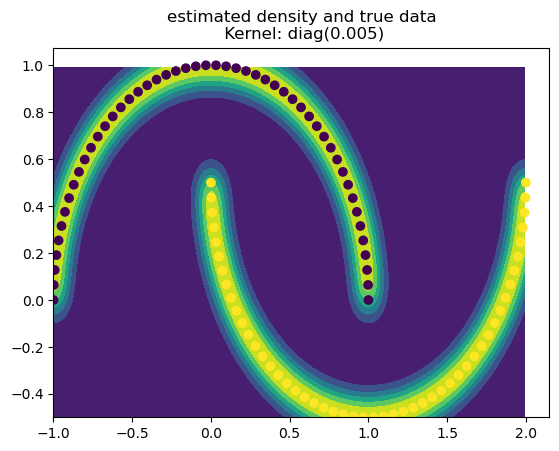

In [36]:
#%% KDE eval

H = np.eye(2)/200 #bandwidth of kernel (cov-matrix)

KDE = KDE_gaussian(x, H)
KDE.density_plot()
plt.scatter(x1, x2, c=y)
plt.title("estimated density and true data\n Kernel: diag(0.005)")

### Evaluation with MMD

Text(0.5, 1.0, 'estimated density and sample\n Kernel: diag(0.005)')

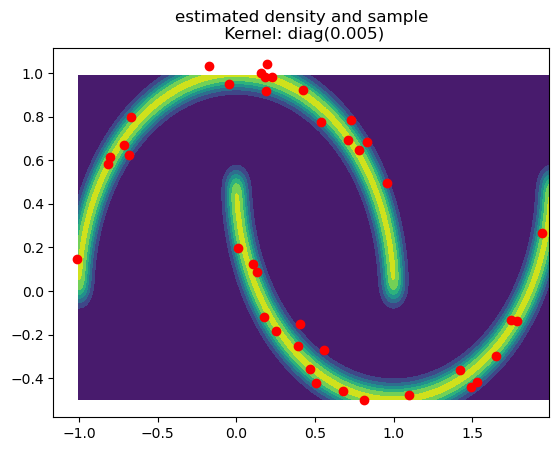

In [63]:
KDE.density_plot()
KDE_sample = np.array(KDE.sample(40))
plt.scatter(KDE_sample[:,0],KDE_sample[:,1], color="red")
plt.title("estimated density and sample\n Kernel: diag(0.005)")

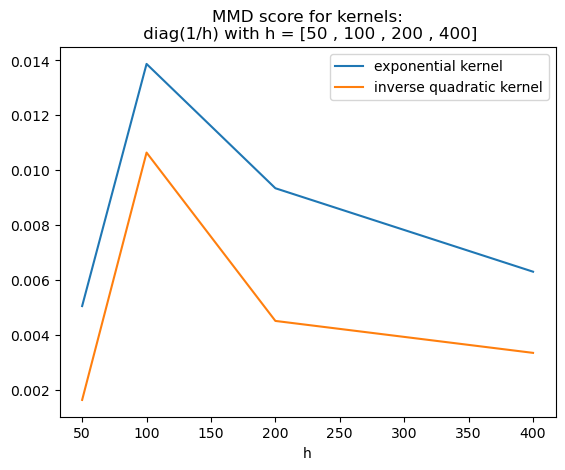

In [40]:
#KDE sample
h = [50, 100, 200, 400]
KDE_samples = []

for n in np.arange(4):
    current_h = h[n]
    H = np.eye(2)/current_h
    KDE= KDE_gaussian(x, H)
    sample = np.array(KDE.sample(40))
    KDE_samples.append(sample)

KDE_exp_GMM = []
KDE_inv_GMM = []
for n in np.arange(4):
    metric_exp = MMD(test_true = x, test_model = KDE_samples[n], kernel = exponential())
    metric_inv = MMD(test_true = x, test_model = KDE_samples[n], kernel = inverse_quadr())
    KDE_exp_GMM.append(metric_exp.out())
    KDE_inv_GMM.append(metric_inv.out())

plt.plot(h, KDE_exp_GMM, label ="exponential kernel")
plt.plot(h, KDE_inv_GMM, label ="inverse quadratic kernel")
plt.title("MMD score for kernels:\n diag(1/h) with h = [50 , 100 , 200 , 400]")
plt.xlabel("h")
plt.legend()

#### Notes
one can observe that
* in the MMD model a higher Number of Gaussians leads to a higher accurracy
* in the KDE model a more narrow bandwidth of the kernel leads to a higher accurracy
* exponential and inverse quadratic kernel used in the MMD behave similar with an offset 

<div style="color: green; font-weight: bold;">Comment:</div>
The KDE implementation is well thought out. Using a bandwidth matrix H allows for more flexibility, but it could be useful to consider an adaptive bandwidth, such as Silverman's rule of thumb, for better fitting. The density_plot() method uses a loop to evaluate the density, which can be quite slow. Consider using scipy.stats.gaussian_kde for a more optimized KDE implementation that can handle such operations more efficiently.

## Exercise 2: Higher dimensional data

In [9]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from quantile_forest import RandomForestQuantileRegressor
from tqdm import tqdm  # for progress bar

In [2]:
def load_data():
    digits = load_digits()
    X = digits.data
    y = digits.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

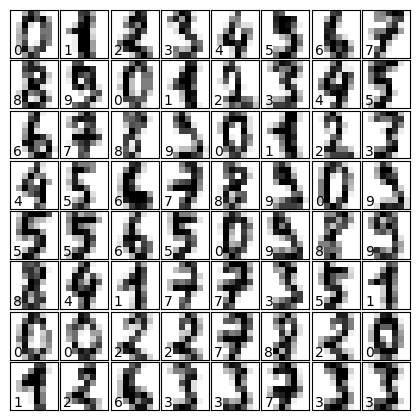

In [28]:
def plot_data():
    digits = load_digits()
    fig = plt.figure(figsize=(4, 4))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(digits.target[i]))
    
    plt.show()

plot_data()

<div style="color: green; font-weight: bold;">Comment:</div> The dataset representation is well structured and makes effective use of the `load_digits` dataset. The visualization effectively displays the digit images, but consider providing more descriptive titles or axis labels to make the plot more informative. This can help users better understand the output, especially if they are not familiar with the dataset.

In [5]:
X_train = load_data()[0]
X_test = load_data()[1]
y_train = load_data()[2]
y_test = load_data()[3]


kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X_train)
gmm = GaussianMixture(n_components=10).fit(X_train)
qrf = RandomForestQuantileRegressor().fit(X_train, y_train)

In [6]:
NUMBER_OF_GENERATED_DATA = 1000

def generate_data_from_kde(kde):
    """
    Function which generates data from KDE model.

    Args:
        kde (sklearn.neighbors.KernelDensity): KDE model.
    """
    new_data = kde.sample(NUMBER_OF_GENERATED_DATA)
    return new_data

def generate_data_from_gmm(gmm):
    """
    Function which generates data from GMM model.

    Args:
        gmm (sklearn.mixture.GMM): GMM model.
    """
    new_data = gmm.sample(NUMBER_OF_GENERATED_DATA)[0]
    return new_data

def generate_data_from_qrf(qrf):
    """
    Function which generates data from Quantile Random Forest model.

    Args:
        qrf (sklearn.ensemble.RandomForestQuantileRegressor): Quantile Random Forest model.
    """
    new_data = qrf.predict(X_test)
    return new_data

new_data_kde = generate_data_from_kde(kde)
new_data_gmm = generate_data_from_gmm(gmm)

<div style="color: green; font-weight: bold;">Comment:</div> The initialization of KDE, GMM, and Quantile Random Forest models is appropriate. However, the `bandwidth` parameter for KDE can be critical for performance, and it may be helpful to test different values or use cross-validation to find the optimal bandwidth. Similarly, for GMM, consider using `kmeans_plusplus` initialization to improve convergence.

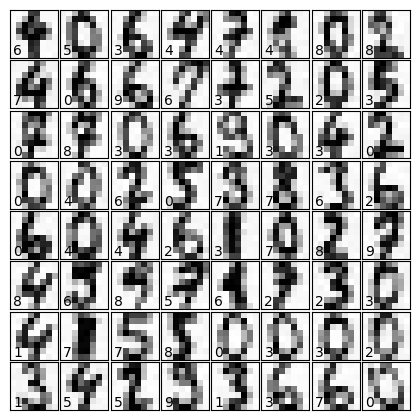

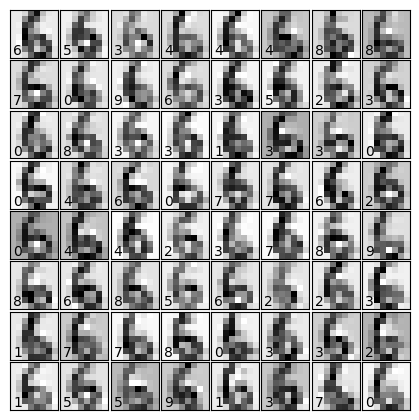

In [8]:
# We now plot the generated data with KDE and GMM

def plot_data_kde():
    fig = plt.figure(figsize=(4, 4))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(new_data_kde[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(y_train[i]))

    plt.show()

plot_data_kde()

def plot_data_gmm():
    fig = plt.figure(figsize=(4, 4))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(new_data_gmm[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(y_train[i]))

    plt.show()

plot_data_gmm()

<div style="color: green; font-weight: bold;">Comment:</div> The plotting functions for KDE and GMM generated data are well designed and provide an easy visual comparison of the generated samples. Consider using a more distinctive color map or annotations to clearly differentiate between the original and generated data, which would make the plots more informative

In [10]:
# Define the Squared Exponential kernel
def squared_exponential_kernel(X, Y, sigma=1.0):
    """Compute the squared exponential kernel between two matrices."""
    pairwise_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return np.exp(-pairwise_dists / (2 * sigma ** 2))

# Define the Inverse Quadratic kernel
def inverse_quadratic_kernel(X, Y, c=1.0):
    """Compute the inverse quadratic kernel between two matrices."""
    pairwise_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return 1 / (1 + pairwise_dists / c)

# Function to compute Maximum Mean Discrepancy (MMD) with a chosen kernel
def compute_mmd(X, Y, kernel_func, **kernel_params):
    """
    Computes the Maximum Mean Discrepancy (MMD) between two samples X and Y using a custom kernel.

    Args:
        X (np.ndarray): First sample (original data).
        Y (np.ndarray): Second sample (generated data).
        kernel_func (function): Kernel function to use.
        kernel_params (dict): Additional parameters for the kernel function.

    Returns:
        float: MMD value.
    """
    XX = kernel_func(X, X, **kernel_params)
    YY = kernel_func(Y, Y, **kernel_params)
    XY = kernel_func(X, Y, **kernel_params)
    mmd = np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)
    return mmd

<div style="color: green; font-weight: bold;">Comment:</div> The implementation of the kernel functions is correct. However, calculating pairwise distances manually can be quite inefficient for large datasets. Consider using the `scipy.spatial.distance.cdist()` function for better performance and readability.

In [11]:
# Define range of hyperparameter values for GMM (n_components) and KDE (bandwidth)
n_components_range = range(1, 21)  # Try different numbers of components for GMM
bandwidth_range = np.linspace(0.1, 1.0, 10)  # Different bandwidths for KDE

# Store MMD results for each hyperparameter value
mmd_results_gmm_se = []
mmd_results_kde_se = []
mmd_results_gmm_iq = []
mmd_results_kde_iq = []

# Parameters for the kernels
sigma_se = 1.0  # Sigma for squared exponential kernel
c_iq = 1.0      # c parameter for inverse quadratic kernel

# Calculate MMD for GMM with varying number of components using squared exponential kernel
for n_components in tqdm(n_components_range, desc="GMM MMD Calculation (Squared Exponential)"):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_train)
    generated_data_gmm = gmm.sample(NUMBER_OF_GENERATED_DATA)[0]
    mmd_se = compute_mmd(X_train, generated_data_gmm, squared_exponential_kernel, sigma=sigma_se)
    mmd_results_gmm_se.append(mmd_se)

# Calculate MMD for KDE with varying bandwidth using squared exponential kernel
for bandwidth in tqdm(bandwidth_range, desc="KDE MMD Calculation (Squared Exponential)"):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_train)
    generated_data_kde = kde.sample(NUMBER_OF_GENERATED_DATA)
    mmd_se = compute_mmd(X_train, generated_data_kde, squared_exponential_kernel, sigma=sigma_se)
    mmd_results_kde_se.append(mmd_se)

# Calculate MMD for GMM with varying number of components using inverse quadratic kernel
for n_components in tqdm(n_components_range, desc="GMM MMD Calculation (Inverse Quadratic)"):
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_train)
    generated_data_gmm = gmm.sample(NUMBER_OF_GENERATED_DATA)[0]
    mmd_iq = compute_mmd(X_train, generated_data_gmm, inverse_quadratic_kernel, c=c_iq)
    mmd_results_gmm_iq.append(mmd_iq)

# Calculate MMD for KDE with varying bandwidth using inverse quadratic kernel
for bandwidth in tqdm(bandwidth_range, desc="KDE MMD Calculation (Inverse Quadratic)"):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X_train)
    generated_data_kde = kde.sample(NUMBER_OF_GENERATED_DATA)
    mmd_iq = compute_mmd(X_train, generated_data_kde, inverse_quadratic_kernel, c=c_iq)
    mmd_results_kde_iq.append(mmd_iq)

KDE MMD Calculation (Inverse Quadratic): 100%|█████████████████████████████████████████| 10/10 [00:01<00:00,  6.85it/s]


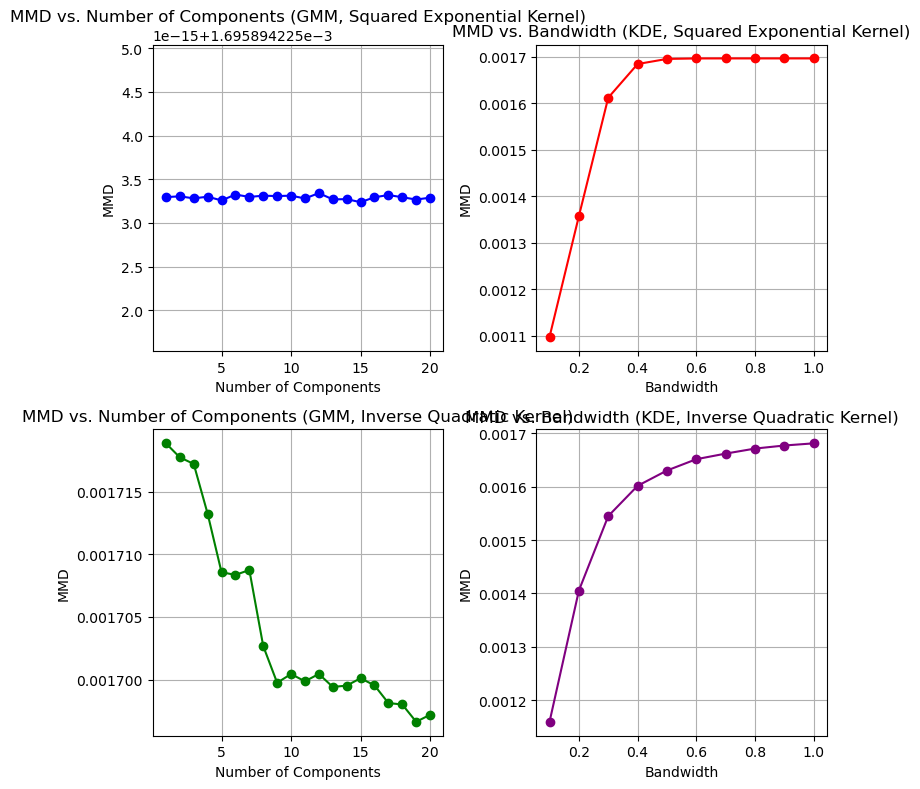

In [14]:
# Plot MMD as a function of the hyperparameters
plt.figure(figsize=(8, 8))

# Plot for GMM with squared exponential kernel
plt.subplot(2, 2, 1)
plt.plot(n_components_range, mmd_results_gmm_se, marker='o', color='b')
plt.title("MMD vs. Number of Components (GMM, Squared Exponential Kernel)")
plt.xlabel("Number of Components")
plt.ylabel("MMD")
plt.grid(True)

# Plot for KDE with squared exponential kernel
plt.subplot(2, 2, 2)
plt.plot(bandwidth_range, mmd_results_kde_se, marker='o', color='r')
plt.title("MMD vs. Bandwidth (KDE, Squared Exponential Kernel)")
plt.xlabel("Bandwidth")
plt.ylabel("MMD")
plt.grid(True)

# Plot for GMM with inverse quadratic kernel
plt.subplot(2, 2, 3)
plt.plot(n_components_range, mmd_results_gmm_iq, marker='o', color='g')
plt.title("MMD vs. Number of Components (GMM, Inverse Quadratic Kernel)")
plt.xlabel("Number of Components")
plt.ylabel("MMD")
plt.grid(True)

# Plot for KDE with inverse quadratic kernel
plt.subplot(2, 2, 4)
plt.plot(bandwidth_range, mmd_results_kde_iq, marker='o', color='purple')
plt.title("MMD vs. Bandwidth (KDE, Inverse Quadratic Kernel)")
plt.xlabel("Bandwidth")
plt.ylabel("MMD")
plt.grid(True)

plt.tight_layout()
plt.show()

<div style="color: green; font-weight: bold;">Comment:</div> The function `compute_mmd` is correct in terms of logic, but it can be computationally intensive for large datasets. Vectorizing the kernel calculations using `scipy` functions can make the computation faster and reduce memory overhead.

In [20]:
#We now want to train a sklearn.ensemble.RandomForestClassifier on the original dataset to distinguish the 10 digit classes.

def train_qrf(X_train, y_train):
    qrf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
    return qrf

qrf = train_qrf(X_train, y_train)

#We want to use this the qrf classifier to check how often gmm and kde generated each difig

def predict_qrf(qrf, new_data):
    predictions = qrf.predict(new_data)
    return predictions

predictions_qrf_gmm = predict_qrf(qrf, new_data_gmm)
predictions_qrf_kde = predict_qrf(qrf, new_data_kde)

<div style="color: green; font-weight: bold;">Comment:</div> The random forest classifier is a good choice for evaluating the generated data. However, using only 10 estimators might limit the model's accuracy. Consider increasing the number of estimators to improve the robustness of your evaluation. Additionally, explicitly splitting the data for cross-validation could provide more insight into the performance of the classifier on generated data.

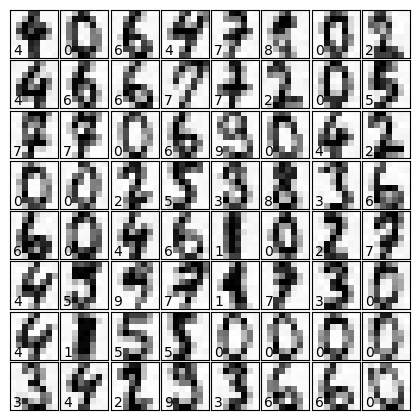

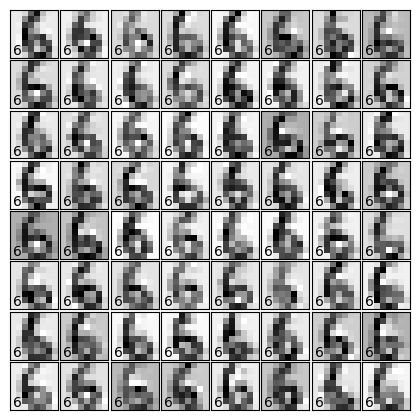

[4 0 6 4 7 8 0 2 4 6 6 7 7 2 0 5 7 7 0 6 9 0 4 2 0 0 2 5 3 8 3 6 6 0 4 6 1
 0 2 7 4 5 9 7 1 7 3 0 4 1 5 5 0 0 0 0 3 4 2 9 3 6 6 0 8 7 3 6 9 2 3 5 3 5
 6 3 7 1 0 4 1 9 2 9 6 3 0 7 7 0 6 1 1 9 1 3 1 8 4 6 5 1 9 7 9 8 5 1 6 1 4
 0 8 7 5 9 8 3 2 5 1 4 9 7 6 9 4 9 8 3 1 0 0 1 7 3 8 1 3 7 4 0 9 9 6 8 4 3
 7 5 5 9 6 6 3 0 8 5 9 7 4 8 9 8 4 6 7 8 4 7 3 3 6 5 3 2 7 6 4 5 1 5 2 7 5
 0 5 8 2 6 0 3 9 7 6 9 7 8 0 3 9 3 9 0 7 2 8 3 0 4 0 1 7 7 3 5 9 2 3 4 9 9
 7 6 8 7 9 3 2 0 5 6 0 9 0 5 8 1 4 6 2 3 1 0 6 4 2 0 6 6 7 1 4 0 3 8 6 3 1
 3 9 8 4 6 8 5 6 7 9 6 8 3 9 6 9 5 9 5 7 3 5 2 4 7 3 5 1 6 6 9 1 2 1 2 3 2
 5 4 7 8 8 7 2 9 7 2 7 1 6 8 1 5 4 3 5 6 4 5 6 5 0 1 1 3 6 4 3 0 3 2 8 2 6
 0 8 3 8 8 8 2 2 1 6 8 4 3 2 7 5 2 2 5 3 9 9 8 0 5 2 0 7 3 0 5 7 3 7 4 3 8
 5 1 8 4 9 5 1 7 4 0 8 2 4 3 7 8 4 6 3 5 2 6 9 4 4 2 4 8 6 7 2 7 3 2 3 0 1
 9 3 2 9 4 9 0 9 6 6 2 8 4 9 2 0 9 3 4 1 8 7 9 0 4 0 3 1 5 9 5 8 6 5 8 7 2
 7 4 3 0 4 0 7 9 6 6 3 5 7 9 0 4 1 0 1 0 5 8 2 2 7 9 2 9 9 0 0 0 5 7 3 5 7
 8 5 5 4 6 7 0 5 9 5 2 3 

In [24]:
def plot_qrf_kde(predictions_qrf):
    fig = plt.figure(figsize=(4, 4))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(new_data_kde[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(predictions_qrf[i]))

    plt.show()

plot_qrf_kde(predictions_qrf_kde)

def plot_qrf_gmm(predictions_qrf):
    fig = plt.figure(figsize=(4, 4))  # figure size in inches
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
        ax.imshow(new_data_gmm[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
        # label the image with the target value
        ax.text(0, 7, str(predictions_qrf[i]))

    plt.show()

plot_qrf_gmm(predictions_qrf_gmm)

print(predictions_qrf_kde)
print(predictions_qrf_gmm)

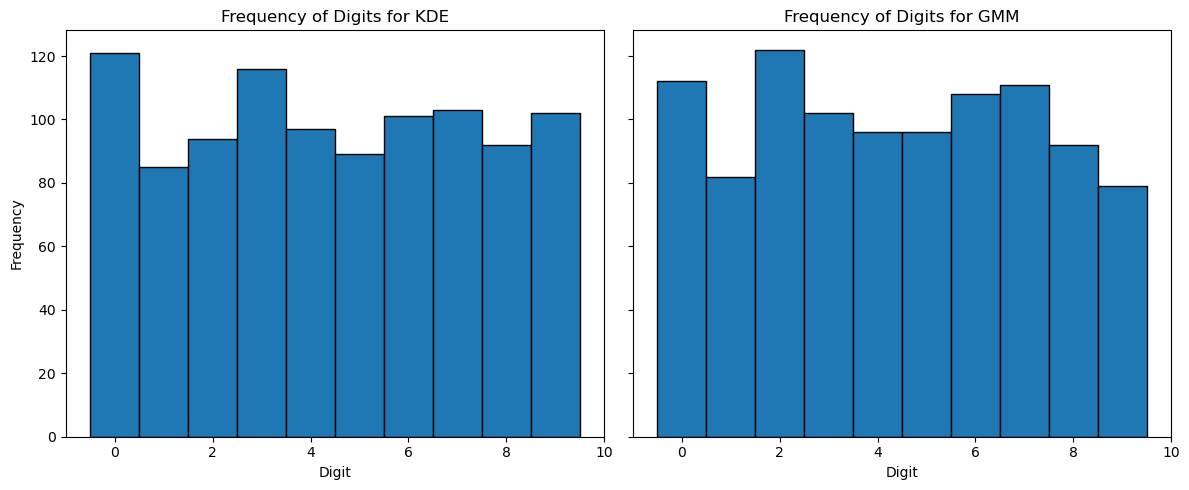

In [23]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot histogram for the first dataset
axes[0].hist(predictions_qrf_kde, bins=range(11), edgecolor='black', align='left')
axes[0].set_title('Frequency of Digits for KDE')
axes[0].set_xlabel('Digit')
axes[0].set_ylabel('Frequency')

# Plot histogram for the second dataset
axes[1].hist(predictions_qrf_gmm, bins=range(11), edgecolor='black', align='left')
axes[1].set_title('Frequency of Digits for GMM')
axes[1].set_xlabel('Digit')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

<div style="color: green; font-weight: bold;">Comment:</div> The histograms provide an insightful comparison of the frequency of generated digits for KDE and GMM. However, consider normalizing the histograms to present the proportion of each class. This will help compare the distribution of generated data to the original dataset more effectively.